### Importing Libraries

In [1]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-06-12 05:38:17.938636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749706698.373078      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749706698.492395      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

In [2]:
# 📁 Paths
train_csv_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'
test_csv_path = '/kaggle/input/rsna-bone-age/boneage-test-dataset.csv'
train_img_dir = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
test_img_dir = '/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'

In [3]:
# 📄 Load CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
train_df.columns

Index(['id', 'boneage', 'male'], dtype='object')

In [5]:
test_df.columns

Index(['Case ID', 'Sex'], dtype='object')

In [6]:
# 🖼 Add image paths
train_df['path'] = train_df['id'].astype(str) + '.png'
test_df['path'] = test_df['Case ID'].astype(str) + '.png'

In [7]:
# 📊 Normalize target
mean_boneage = train_df['boneage'].mean()
std_boneage = train_df['boneage'].std()
train_df['boneage_z'] = (train_df['boneage'] - mean_boneage) / std_boneage

In [8]:
# 🔀 Train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.15, random_state=42)

## Data Augmentation

In [9]:
# 📈 Data Generator
class BoneAgeGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, img_size=224, batch_size=32, training=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.training = training
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, genders, labels = [], [], []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row['path'])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, 3, axis=-1)  # Convert to 3-channel RGB

            if self.augment:
                img = self.datagen.random_transform(img)

            images.append(img)
            genders.append(row['male'])
            if self.training:
                labels.append(row['boneage_z'])

        images = np.array(images)
        genders = np.array(genders).reshape(-1, 1)

        if self.training:
            return (images, genders), np.array(labels)
        else:
            return(images, genders)

## Model Training

### EfficientNetB0 Model

In [10]:
# ⚙️ Model
def build_model(img_size=224):
    img_input = Input(shape=(img_size, img_size, 3))
    gender_input = Input(shape=(1,))
    
    base = EfficientNetB0(include_top=False, input_tensor=img_input, weights='imagenet')
    x = GlobalAveragePooling2D()(base.output)
    x = Concatenate()([x, gender_input])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='linear')(x)

    return Model(inputs=[img_input, gender_input], outputs=output)

In [11]:
# 📦 Data Generators
train_gen = BoneAgeGenerator(train_data, train_img_dir, augment=True)
val_gen = BoneAgeGenerator(val_data, train_img_dir, augment=False)

In [12]:
# 🔧 Compile
model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

I0000 00:00:1749706716.800591      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749706716.801333      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# ✅ Callbacks
checkpoint = ModelCheckpoint("/kaggle/working/best_model.keras", monitor='val_mae', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=3, verbose=1)

In [14]:
# 🏋️ Train
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    callbacks=[checkpoint, early_stop, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1749706780.547215      62 service.cc:148] XLA service 0x7b06ac1ab2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749706780.548872      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749706780.548897      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749706785.921607      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749706797.074182      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749706797.218630      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749706797.674820      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 82/335 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - loss: 0.7376 - mae: 0.6663

E0000 00:00:1749706958.660667      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749706958.805817      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749706959.255577      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749706959.397775      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4869 - mae: 0.5324
Epoch 1: val_mae improved from inf to 1.00297, saving model to /kaggle/working/best_model.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 732s 2s/step - loss: 0.4864 - mae: 0.5321 - val_loss: 1.3728 - val_mae: 1.0030 - learning_rate: 0.0010
Epoch 2/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1685 - mae: 0.3222
Epoch 2: val_mae did not improve from 1.00297
335/335 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - loss: 0.1685 - mae: 0.3222 - val_loss: 2.5696 - val_mae: 1.4064 - learning_rate: 0.0010
Epoch 3/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1293 - mae: 0.2812
Epoch 3: val_mae improved from 1.00297 to 0.86515, saving model to /kaggle/working/best_model.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - loss: 0.1292 - mae: 0.2812 - val_loss: 1.0543 - val_mae: 0.8652 - learning_rate: 0.0010
Epoch 4/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1073 - mae: 0.2543
Epoch 4: val_mae did not improve from 0.86515
335/335

#### Graphs Plotting

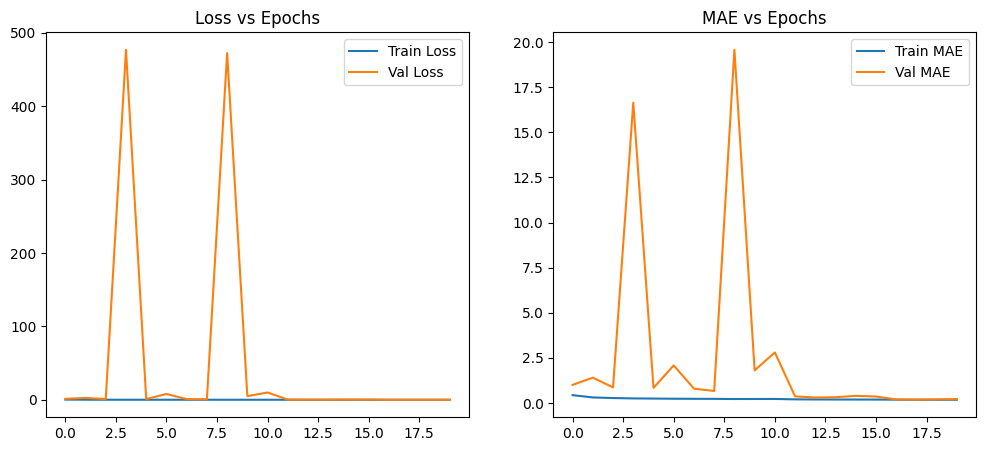

In [15]:
# 📉 Plot Loss & MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE vs Epochs')
plt.legend()
plt.show()

#### Performace Metrices

In [16]:
# from tensorflow.keras.models import load_model

# model = load_model("/kaggle/input/effecientnetb0-model-rsna-dataset/keras/default/1/best_model.keras")  # or whatever path you used

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
📌 Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         1
           8       1.00      0.29      0.44         7
           9       0.25      0.50      0.33         2
          10       0.86      0.67      0.75         9
          11       0.50      1.00      0.67         2
          12       0.33      0.50      0.40         2
          13       0.00      0.00      0.00         1
          14       0.67      0.50      0.57         4
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1

    accuracy                           0.50        32
   macro avg       0.43      0.45      0.40        32
weighted avg       0.66      0.50      0.52        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


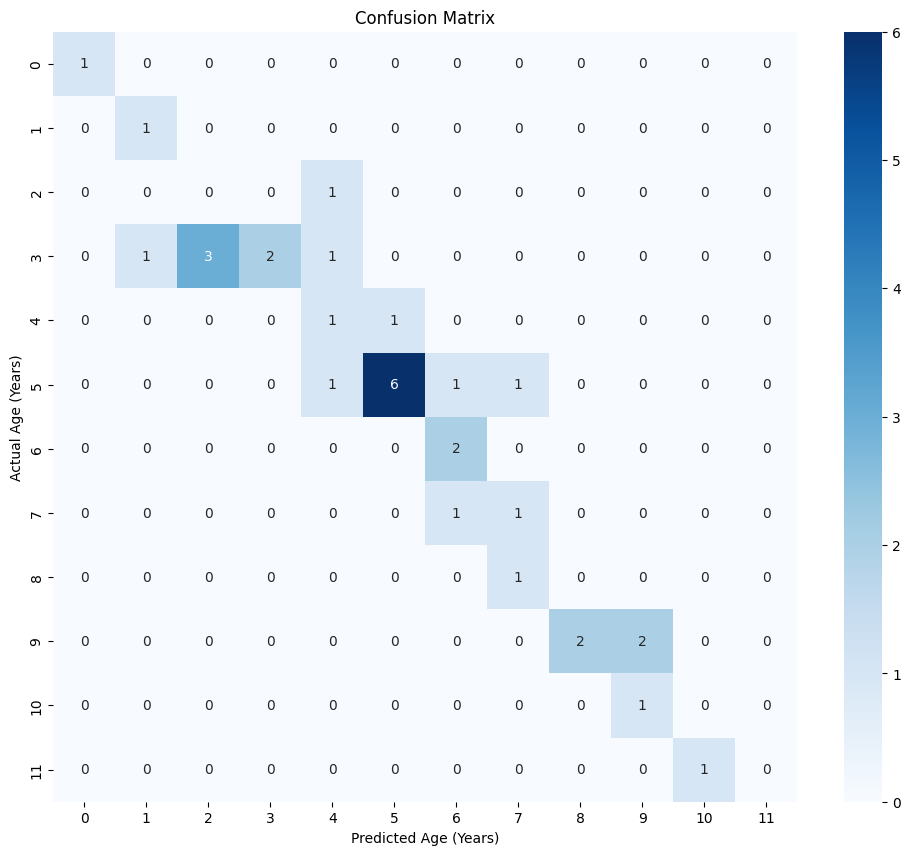

In [17]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred = model.predict((val_imgs, val_gender)).flatten()
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# 🎯 Convert to age classes (rounded to years)
y_true_cls = np.round(y_true / 12).astype(int)
y_pred_cls = np.round(y_pred / 12).astype(int)

# 📊 Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("📌 Classification Report:")
print(classification_report(y_true_cls, y_pred_cls))

# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix")
plt.show()

#### On Complete Validation Set

In [18]:
# 🔁 Accumulate predictions and ground truths across all batches
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model.predict((imgs, genders)).flatten()

    # Unnormalize
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━

In [19]:
# 🎯 Convert to age classes (rounded to nearest year)
y_true_cls = np.round(np.array(all_y_true) / 12).astype(int)
y_pred_cls = np.round(np.array(all_y_pred) / 12).astype(int)

📌 Classification Report (Full Validation Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.38      0.55         8
           2       0.67      0.48      0.56        25
           3       0.50      0.53      0.51        36
           4       0.44      0.40      0.42        48
           5       0.27      0.31      0.29        49
           6       0.50      0.44      0.47        97
           7       0.43      0.49      0.46        99
           8       0.48      0.48      0.48       142
           9       0.37      0.48      0.42       124
          10       0.42      0.42      0.42       186
          11       0.30      0.44      0.36       144
          12       0.58      0.51      0.55       294
          13       0.36      0.48      0.41       183
          14       0.73      0.42      0.53       262
          15       0.38      0.44      0.41        72
          16       0.50      0.33 

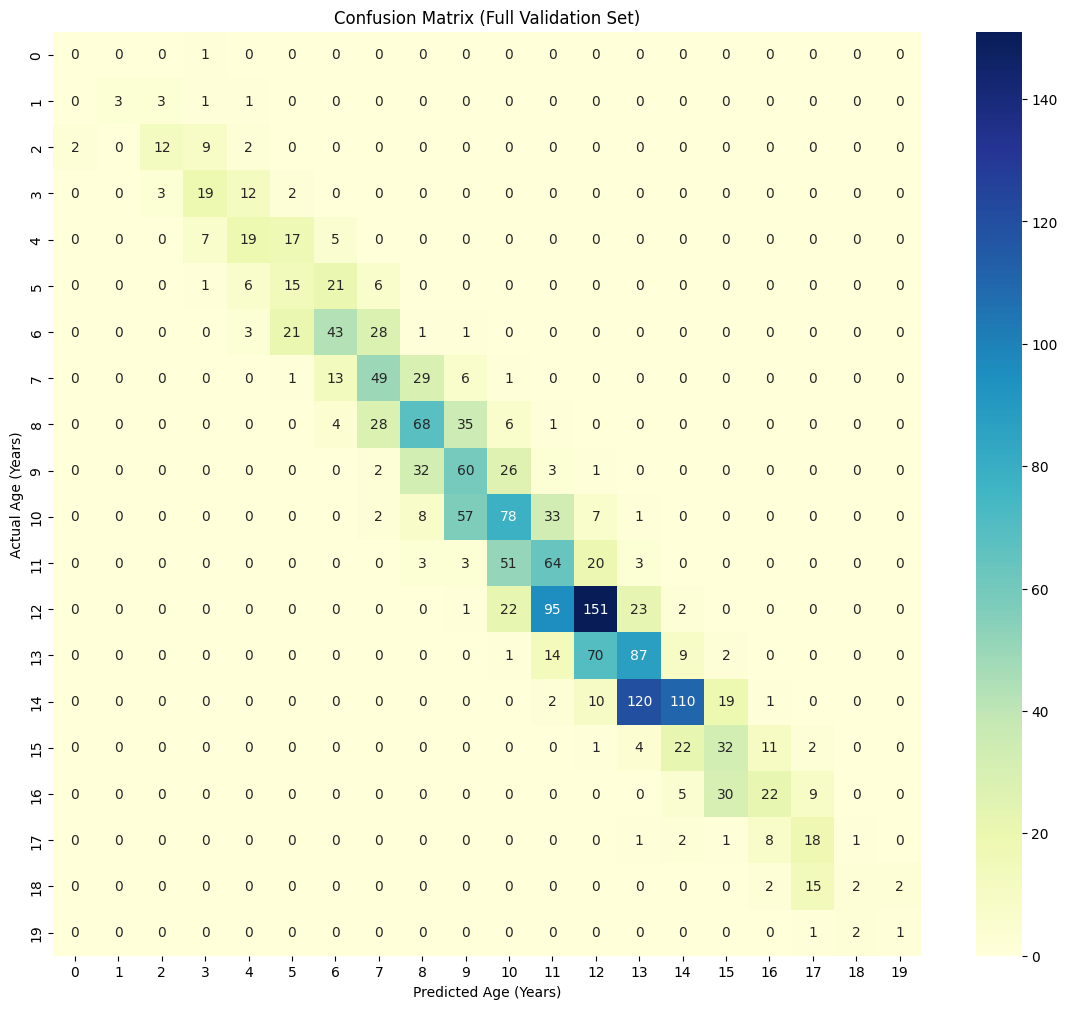

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📝 Report
print("📌 Classification Report (Full Validation Set):")
print(classification_report(y_true_cls, y_pred_cls))

# 🔷 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix (Full Validation Set)")
plt.show()

In [21]:
import pandas as pd

results_df = pd.DataFrame({
    'True_Bone_Age_Months': all_y_true,
    'Pred_Bone_Age_Months': all_y_pred,
    'True_Age_Years': y_true_cls,
    'Pred_Age_Years': y_pred_cls
})

results_df.to_csv("validation_predictions.csv", index=False)

## Regression Model

### EffecientNetB0

#### Preliminaries (Preprocessing & Loading CSVs)

In [22]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# === Paths ===
TRAIN_DIR = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
CSV_PATH = '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'

df = pd.read_csv(CSV_PATH)

# Add gender as int (Male: 1, Female: 0)
df['gender'] = df['male'].astype(int)

# Normalize target
mean_boneage = df['boneage'].mean()
std_boneage = df['boneage'].std()
df['boneage_z'] = (df['boneage'] - mean_boneage) / std_boneage

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

#### 🧹 Data Generator (Regression + 2 Inputs)

In [23]:
class BoneAgeGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=32, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.augment = augment
        self.indexes = np.arange(len(df))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_gender = []
        batch_labels = []
    
        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, f"{row['id']}.png")
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = preprocess_input(img)
    
            if self.augment:
                img = tf.image.random_flip_left_right(img)
    
            batch_imgs.append(img)
            batch_gender.append([row['gender']])
            batch_labels.append(row['boneage_z'])
    
        return (np.array(batch_imgs), np.array(batch_gender)), np.array(batch_labels)

#### 🧠 Model Architecture (Regression + Gender)

In [24]:
# Inputs
img_input = Input(shape=(224, 224, 3), name='img_input')
gender_input = Input(shape=(1,), name='gender_input')

# CNN Feature Extractor
base_model = EfficientNetB0(include_top=False, input_tensor=img_input, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)

# Combine with gender
x = Concatenate()([x, gender_input])
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[img_input, gender_input], outputs=output)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,221,988 (16.11 MB)

 Trainable params: 4,179,965 (15.95 MB)

 Non-trainable params: 42,023 (164.16 KB)

#### 🏋️ Train the Model

In [25]:
train_gen = BoneAgeGenerator(train_df, TRAIN_DIR, augment=True)
val_gen = BoneAgeGenerator(val_df, TRAIN_DIR, augment=False)

checkpoint = ModelCheckpoint('best_boneage_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=30,
                    callbacks=[checkpoint, early_stop, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
227/316 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - loss: 0.5854 - mae: 0.5854

E0000 00:00:1749716599.353400      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749716599.490534      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


316/316 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - loss: 0.5548 - mae: 0.5548 - val_loss: 0.4092 - val_mae: 0.4092 - learning_rate: 0.0010
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - loss: 0.3578 - mae: 0.3578 - val_loss: 0.2786 - val_mae: 0.2786 - learning_rate: 0.0010
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - loss: 0.3058 - mae: 0.3058 - val_loss: 0.2705 - val_mae: 0.2705 - learning_rate: 0.0010
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - loss: 0.2834 - mae: 0.2834 - val_loss: 0.2577 - val_mae: 0.2577 - learning_rate: 0.0010
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - loss: 0.2546 - mae: 0.2546 - val_loss: 0.2754 - val_mae: 0.2754 - learning_rate: 0.0010
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - loss: 0.2501 - mae: 0.2501 - val_loss: 0.3114 - val_mae: 0.3114 - learning_rate: 0.0010
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - loss: 0.2408 - mae: 0.2408 - val_loss: 0.2508 - val_mae: 0.2508 - learning_rate: 0.0010
Epoch 8/30

#### 📉 Training Curves

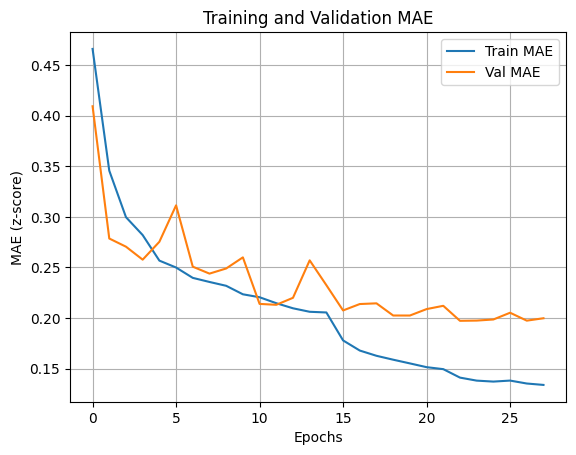

In [26]:
plt.plot(history.history['loss'], label='Train MAE')
plt.plot(history.history['val_loss'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE (z-score)')
plt.legend()
plt.title("Training and Validation MAE")
plt.grid(True)
plt.show()

#### 📊 Evaluation (Denormalized)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📏 MAE: 7.84 months
📏 RMSE: 11.37 months


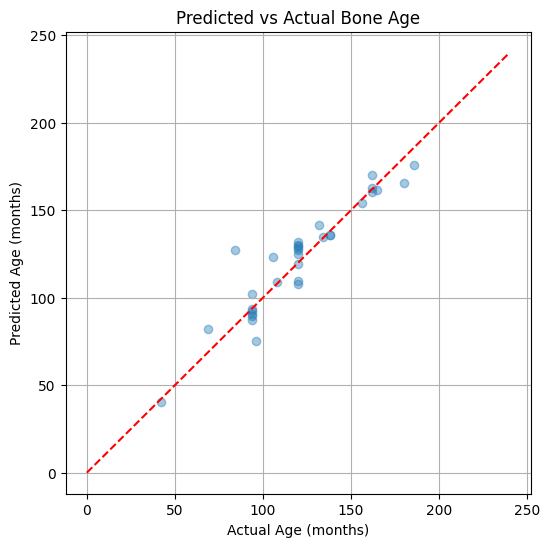

In [ ]:
[val_imgs, val_gender], y_true_z = val_gen[0]
y_pred_z = model.predict([val_imgs, val_gender]).flatten()

# Convert z to original scale
y_pred = y_pred_z * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# MAE, RMSE
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

print(f"📏 MAE: {mae:.2f} months")
print(f"📏 RMSE: {rmse:.2f} months")

# Optional: scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age")
plt.plot([0, 240], [0, 240], '--', color='red')
plt.grid(True)
plt.show()